In [30]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.lick_utils import load_licks
from utils.combine_tools import apply_qc, to_str_intlike

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO

import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import shutil 
from aind_ephys_utils import align
%matplotlib inline

In [60]:
session = 'behavior_782394_2025-04-24_12-07-34'
opto_only = True
def plot_unit_licks(session, unit_ids = None, opto_only=True, data_type='curated', plot_licks=False):
    session_tbl = get_session_tbl(session)
    if session_tbl is None or len(session_tbl) == 0:
        print(f'No session table found for session {session}.')
        return
    unit_tbl = get_unit_tbl(session, 'curated')
    if unit_tbl is None or len(unit_tbl) == 0:
        print(f'No units found for session {session} with data type {data_type}.')
        return
    licks = load_licks(session, plot=plot_licks)
    session_dir = session_dirs(session)
    qm_dir = os.path.join(session_dir['processed_dir'], f'{session}_qm.json')
    with open(qm_dir, 'r') as f:
        qm = json.load(f)
    rec_start = qm['ephys_cut'][0]
    rec_end = qm['ephys_cut'][1]
    if opto_only:
        unit_tbl = unit_tbl[unit_tbl['opto_pass'] == True].reset_index(drop=True)
    if len(unit_tbl) == 0:
        print(f'No opto-responsive units found for session {session}.')
        return
    if unit_ids is None:
        unit_ids = unit_tbl['unit_id'].values
    for unit_id in unit_ids:
        spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
        unit_drift = load_drift(session, unit_id)
        session_tbl_curr = session_tbl.copy()
        spike_times_curr = spike_times.copy()
        lick_starts_L = licks['lick_trains_L']['train_starts']
        lick_starts_R = licks['lick_trains_R']['train_starts']
        lick_starts_in_trial_L = licks['lick_trains_L']['in_trial']
        lick_starts_in_trial_R = licks['lick_trains_R']['in_trial']
        L_mask = np.ones_like(lick_starts_in_trial_L, dtype=bool)
        R_mask = np.ones_like(lick_starts_in_trial_R, dtype=bool)
        L_mask &= lick_starts_L >= rec_start
        R_mask &= lick_starts_R >= rec_start
        L_mask &= lick_starts_L <= rec_end
        R_mask &= lick_starts_R <= rec_end
        
        if unit_drift is not None:
            if unit_drift['ephys_cut'][0] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
                session_tbl_curr = session_tbl_curr[session_tbl_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
                L_mask &= lick_starts_L >= unit_drift['ephys_cut'][0]
                R_mask &= lick_starts_R >= unit_drift['ephys_cut'][0]
            if unit_drift['ephys_cut'][1] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
                session_tbl_curr = session_tbl_curr[session_tbl_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
                L_mask &= lick_starts_L <= unit_drift['ephys_cut'][1]
                R_mask &= lick_starts_R <= unit_drift['ephys_cut'][1]

        lick_starts_in_trial_L = lick_starts_in_trial_L[L_mask]
        lick_starts_in_trial_R = lick_starts_in_trial_R[R_mask]
        lick_starts_L = lick_starts_L[L_mask]
        lick_starts_R = lick_starts_R[R_mask]

        lick_starts_all = np.concatenate([lick_starts_L, lick_starts_R])
        lick_starts_in_trial_all = np.concatenate([lick_starts_in_trial_L, lick_starts_in_trial_R])
        lick_sides = np.concatenate([np.zeros_like(lick_starts_L), np.ones_like(lick_starts_R)])  # 0 for L, 1 for R
        sort_idx = np.argsort(lick_starts_all)
        lick_starts_all = lick_starts_all[sort_idx]
        lick_starts_in_trial_all = lick_starts_in_trial_all[sort_idx]
        lick_sides = lick_sides[sort_idx]
        fig = plt.figure(figsize=(12, 8))
        time_bin = 0.5
        tb = -4
        tf = 4
        gs = gridspec.GridSpec(3, 4)
        custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'red'])
        fig, ax1, ax2 = plot_raster_rate(spike_times_curr, lick_starts_all[~lick_starts_in_trial_all], 
                        lick_sides[~lick_starts_in_trial_all], [-1, 0.5, 2], ['L', 'R'], custom_cmap, 
                        fig, gs[:, 0], time_bin = time_bin,
                        tb= tb, tf = tf)
        ax1.set_title('Spont licks')
        fig, ax1, ax2 = plot_raster_rate(spike_times_curr, lick_starts_L, 
                        lick_starts_in_trial_L, [-1, 0.5, 2], ['out', 'in'], custom_cmap, 
                        fig, gs[:, 1], time_bin = time_bin,
                        tb = tb, tf = tf)
        ax1.set_title('Licks L')
        fig, ax1, ax2 = plot_raster_rate(spike_times_curr, lick_starts_R,
                        lick_starts_in_trial_R, [-1, 0.5, 2], ['out', 'in'], custom_cmap, 
                        fig, gs[:, 2], time_bin = time_bin,
                        tb = tb, tf = tf)
        ax1.set_title('Licks R')
        fig, ax1, ax2 = plot_raster_rate(spike_times_curr, lick_starts_all,
                        lick_starts_in_trial_all, [-1, 0.5, 2], ['out', 'in'], custom_cmap, 
                        fig, gs[:, 3], time_bin = time_bin,
                        tb = tb, tf = tf)
        ax1.set_title('Licks All')

        plt.suptitle(f'Session: {session}, Unit ID: {unit_id}', fontsize=16)
        plt.tight_layout()

        save_path = session_dir['ephys_fig_dir_curated'] + '/lick_raster_rate/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        fig.savefig(save_path + f'unit_{str(unit_id).split(".0")[0]}_lick_raster_{opto_only}.pdf')
        plt.close('all')


In [61]:
plot_unit_licks('behavior_751181_2025-02-26_11-51-19', unit_ids=[77])

In [67]:
dfs = [pd.read_csv('/root/capsule/code/data_management/session_assets.csv'),
        pd.read_csv('/root/capsule/code/data_management/hopkins_session_assets.csv')]
df = pd.concat(dfs)
session_list = df['session_id'].values.tolist()

In [68]:
from joblib import Parallel, delayed
def safe_process(session):
    try:
        plot_unit_licks(session, opto_only=opto_only, plot_licks=True)
    except Exception as e:
        print(f"Error processing session {session}: {e}")
Parallel(n_jobs=-4)(delayed(safe_process)(session) for session in session_list)

No session table found for session ecephys_713854_2024-03-05_12-01-40.
No session table found for session ecephys_713854_2024-03-05_13-01-09.
No session table found for session ecephys_717120_2024-03-06_12-23-53.
No session table found for session ecephys_717120_2024-03-06_12-54-27.
No session table found for session ecephys_713854_2024-03-05_13-31-20.
No session table found for session ecephys_717120_2024-03-07_12-12-02.
No session table found for session ecephys_713854_2024-03-08_16-20-33.
No session table found for session ecephys_713854_2024-03-08_17-15-58.
No session table found for session ecephys_713854_2024-03-08_15-43-01.
No session table found for session ecephys_684930_2023-09-28_11-45-27.
No session table found for session ecephys_684930_2023-09-27_10-04-04.
No session table found for session ecephys_684930_2023-09-28_12-44-15.


In [63]:
# load combined unit tbl
combine_file = os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl')
with open(combine_file, 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
# antidromic data
version = 'PrL_S1'
antidromic_file = f'/root/capsule/scratch/combined/beh_plots/basic_ephys_low/{version}/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

antidromic_df.rename(columns={'unit': 'unit_id'}, inplace=True)
antidromic_df['unit_id'] = antidromic_df['unit_id'].apply(to_str_intlike)
antidromic_df = antidromic_df[['unit_id', 'session', 'p_auto_inhi', 't_auto_inhi',
       'p_collision', 't_collision', 'p_antidromic', 't_antidromic', 'tier_1',
       'tier_2', 'tier_1_long', 'tier_2_long']].copy()
combined_tagged_units = combined_tagged_units.merge(antidromic_df, on=['session', 'unit_id'], how='left')

cols = ['tier_1', 'tier_2', 'tier_1_long', 'tier_2_long']

combined_tagged_units[cols] = (
    combined_tagged_units[cols]
    .fillna(False)
    .astype(bool)
)

Applying conditional bounds for isi_violations
 - isi_violations: 18300 -> 8349 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8349 -> 5876 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5876 -> 5853 units passed
Applying items for in_df: [True]
 - in_df: 5853 -> 4219 units passed
Applying conditional bounds for y_loc
 - y_loc: 4219 -> 2956 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2956 -> 2942 units passed
Applying bounds for sd: [0, 0.3]
 - sd: 2942 -> 1355 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 316
Number of non-opto units after filtering: 1355


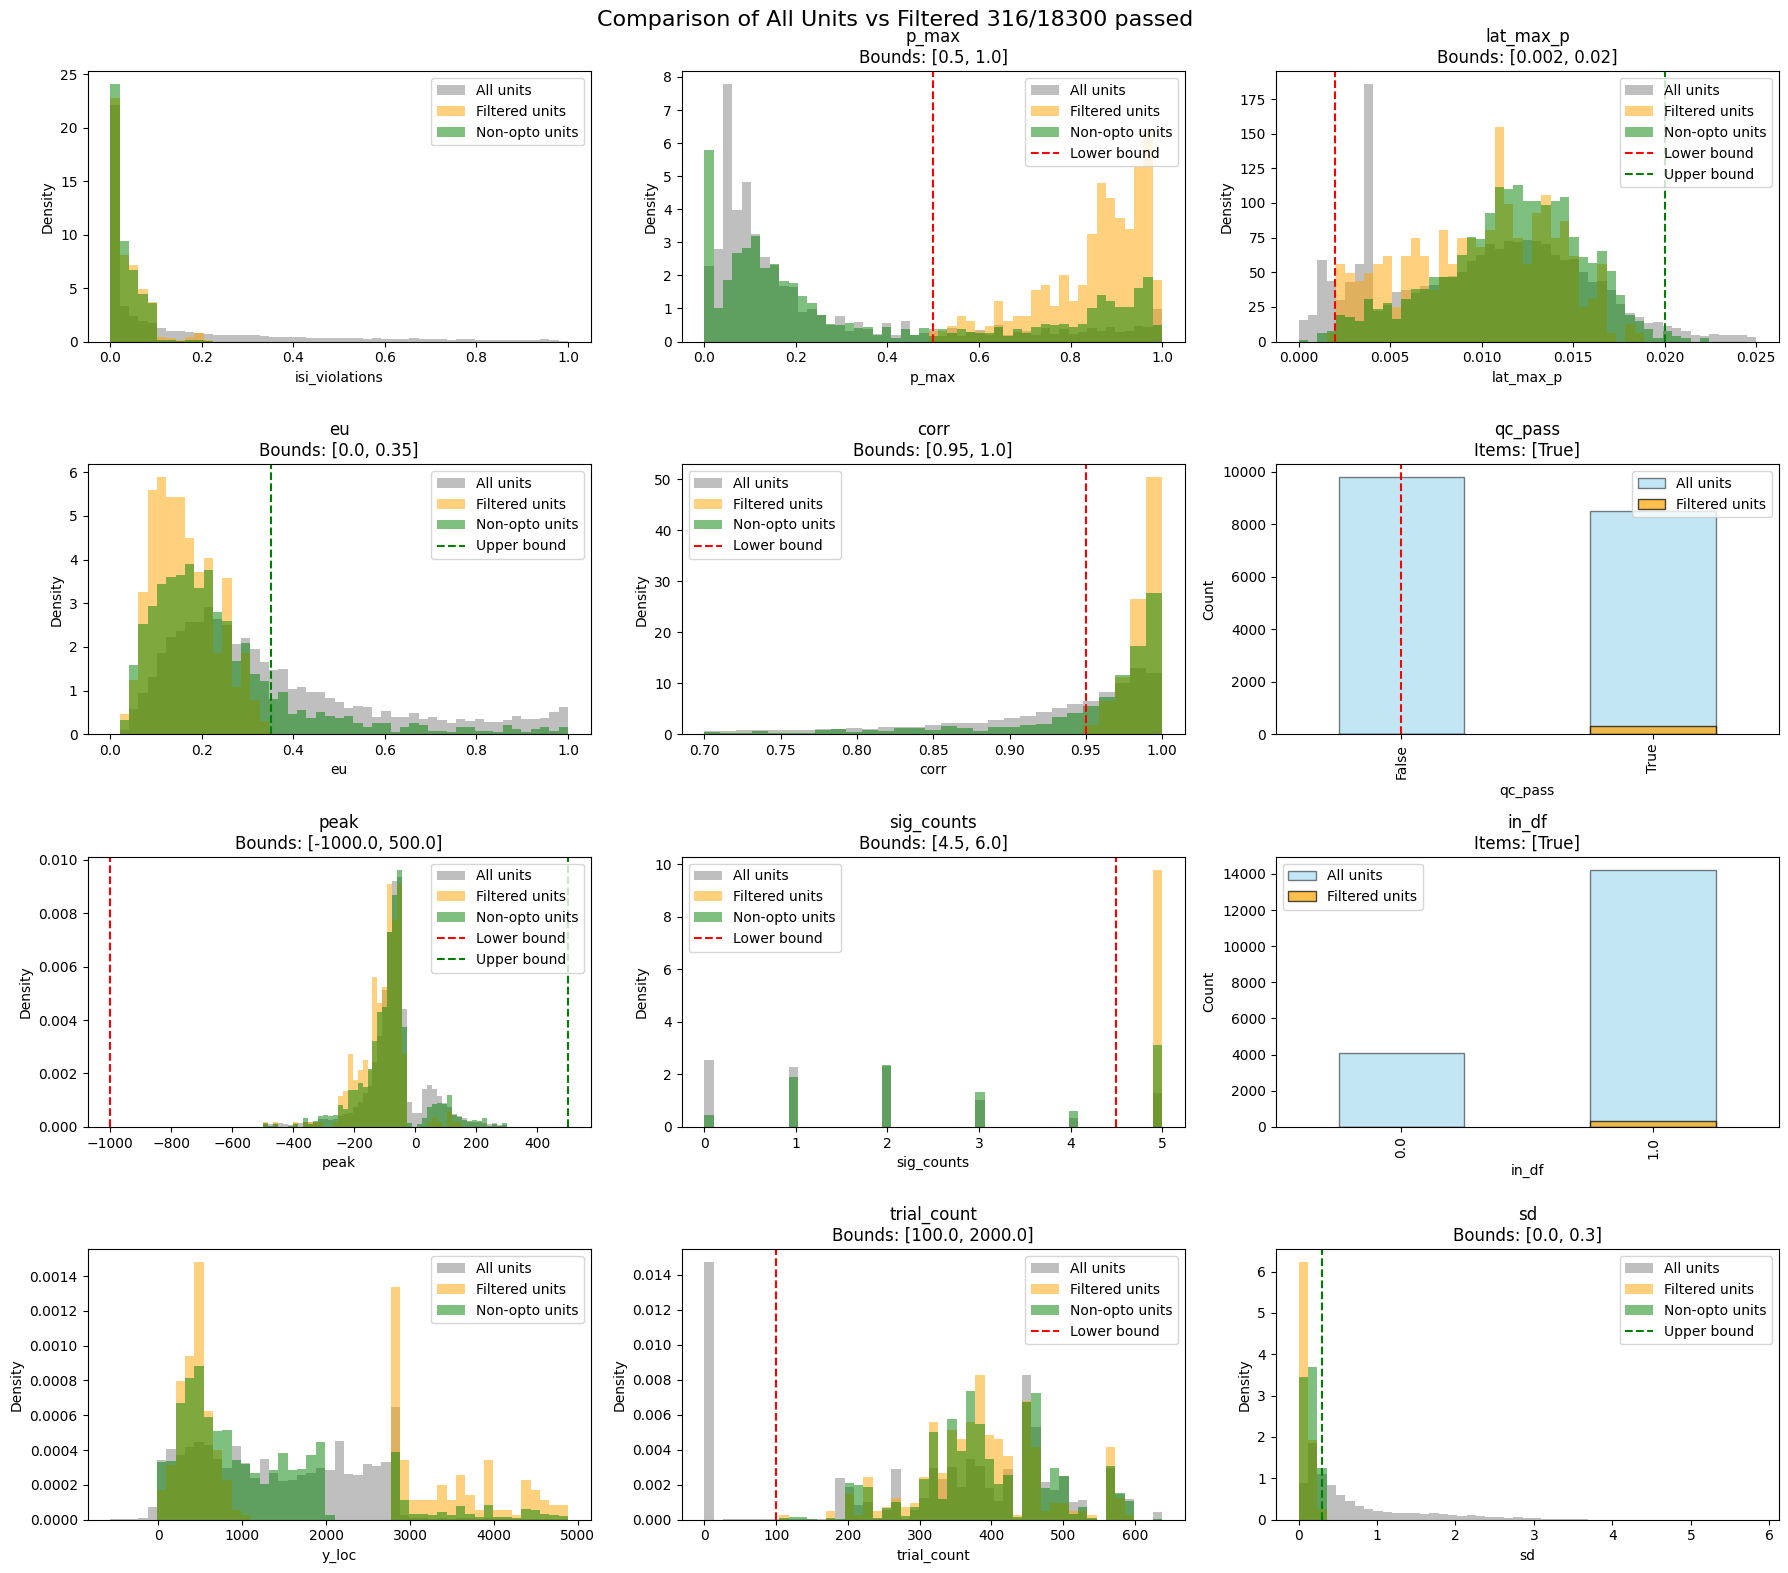

In [66]:
criteria_name = 'beh_all'
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

In [51]:
for row_ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit_id']
    session_dir = session_dirs(session)
    if not os.path.exists(session_dir['ephys_fig_dir_curated'] + '/lick_raster_rate/'):
        print(f'Skipping session {session} as no lick raster directory found.')
        continue
    pdf_path = session_dir['ephys_fig_dir_curated'] + '/lick_raster_rate/' + f'unit_{unit_id}_lick_raster_True.pdf'
    if not os.path.exists(pdf_path):
        print(f'Skipping session {session}, unit {unit_id} as no lick raster plot found.')
        continue
    save_dir = f'/root/capsule/scratch/combined/beh_plots/{criteria_name}/lick_raster/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = save_dir + f'session_{session}_unit_{unit_id}_lick_raster_opto_only.pdf'
    shutil.copy(pdf_path, save_path)
    

Skipping session behavior_751004_2024-12-20_13-26-11, unit 263 as no lick raster plot found.
Skipping session behavior_751004_2024-12-20_13-26-11, unit 268 as no lick raster plot found.
Skipping session behavior_758017_2025-02-04_11-57-38, unit 195 as no lick raster plot found.
Skipping session behavior_758017_2025-02-04_11-57-38, unit 196 as no lick raster plot found.
Skipping session behavior_758017_2025-02-04_11-57-38, unit 199 as no lick raster plot found.
Skipping session behavior_761038_2025-04-18_12-37-39 as no lick raster directory found.
Skipping session behavior_761038_2025-04-18_12-37-39 as no lick raster directory found.
Skipping session behavior_761038_2025-04-18_12-37-39 as no lick raster directory found.
Skipping session behavior_761038_2025-04-18_12-37-39 as no lick raster directory found.
Skipping session behavior_ZS061_2021-03-28_16-35-51, unit TT1_SS_03 as no lick raster plot found.
Skipping session behavior_ZS061_2021-03-28_16-35-51, unit TT3_SS_01 as no lick raster

In [52]:
# combine
save_dir = f'/root/capsule/scratch/combined/beh_plots/{criteria_name}/lick_raster/'
combine_pdf_big(save_dir, os.path.join(save_dir, f'combined_lick_raster_opto_only_{criteria_name}.pdf'))

Processing 314 files in /root/capsule/scratch/combined/beh_plots/beh_all/lick_raster/
Combined PDF saved as: /root/capsule/scratch/combined/beh_plots/beh_all/lick_raster/combined_lick_raster_opto_only_beh_all.pdf


In [37]:
pdf_path

NameError: name 'pdf_path' is not defined